In [1]:
import numpy as np

In [2]:
# Define the main function to solve the 2D Navier-Stokes equations
def navier_stokes_2d(dx, dy, dt, nu, steps, u, v, p):
    # Define a function to build up the b term (for pressure)
    def build_up_b(b, rho, dt, u, v, dx, dy):
        # Compute the b term using the given equation
        b[1:-1, 1:-1] = (rho * (1 / dt * ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) - ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx)) ** 2 - 2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) * (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx)) - ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) ** 2))
        return b

    # Define a function to solve the pressure Poisson equation
    def pressure_poisson(p, dx, dy, b):
        pn = np.empty_like(p)
        for q in range(nit):
            pn = p.copy()
            # Update the pressure using the given equation
            p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy ** 2 + (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx ** 2) / (2 * (dx ** 2 + dy ** 2)) - dx ** 2 * dy ** 2 / (2 * (dx ** 2 + dy ** 2)) * b[1:-1, 1:-1])

            # Apply Neumann boundary conditions for pressure
            p[:, -1] = p[:, -2]
            p[0, :] = p[1, :]
            p[:, 0] = p[:, 1]
            p[-1, :] = p[-2, :]
        return p

    # Define a function to compute the cavity flow
    def cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu):
        un = np.empty_like(u)
        vn = np.empty_like(v)
        b = np.zeros((ny, nx))

        for n in range(nt):
            un = u.copy()
            vn = v.copy()

            # Build up the b term and solve the pressure Poisson equation
            b = build_up_b(b, rho, dt, u, v, dx, dy)
            p = pressure_poisson(p, dx, dy, b)

            # Update the velocity fields (u and v) using the given equations
            u[1:-1, 1:-1] = (un[1:-1, 1:-1] - un[1:-1, 1:-1] * dt / dx * (un[1:-1, 1:-1] - un[1:-1, 0:-2]) - vn[1:-1, 1:-1] * dt / dy * (un[1:-1, 1:-1] - un[0:-2, 1:-1]) - dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) + nu * (dt / dx ** 2 * (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) + dt / dy ** 2 * (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))
            v[1:-1, 1:-1] = (vn[1:-1, 1:-1] - un[1:-1, 1:-1] * dt / dx * (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) - vn[1:-1, 1:-1] * dt / dy * (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) - dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) + nu * (dt / dx ** 2 * (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) + dt / dy ** 2 * (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))

        # Boundary conditions for the obstacle
        obstacle_mask = create_obstacle_mask(nx, ny)
        u[obstacle_mask] = 0
        v[obstacle_mask] = 0

        return u, v, p

    # Define a function to create a boolean mask for the obstacle
    def create_obstacle_mask(nx, ny):
        # Create a boolean mask for the obstacle
        mask = np.zeros((ny, nx), dtype=bool)
        x_center, y_center = nx // 2, ny // 2
        x_width, y_height = nx // 10, ny // 10

        # Set the mask to True for the cells representing the obstacle
        mask[y_center - y_height:y_center + y_height, x_center - x_width:x_center + x_width] = True
        return mask

    ny, nx = u.shape
    rho = 1
    nit = 50

    u_steps, v_steps, p_steps = np.zeros((steps, ny, nx)), np.zeros((steps, ny, nx)), np.zeros((steps, ny, nx))

    # Set initial velocity field: left to right flow
    u[:, 0] = 1
    v[:, :] = 0

    # Set obstacle velocity to zero
    obstacle_mask = create_obstacle_mask(nx, ny)
    u[obstacle_mask] = 0
    v[obstacle_mask] = 0

    for i in range(steps):
        u, v, p = cavity_flow(1, u, v, dt, dx, dy, p, rho, nu)
        u_steps[i, :, :] = u
        v_steps[i, :, :] = v
        p_steps[i, :, :] = p

    return u_steps, v_steps, p_steps

In [3]:
# Simulation parameters
dx = 0.01
dy = 0.01
dt = 0.001
nu = 0.01
steps = 100

# Initial conditions
u = np.zeros((int(1/dy)+1, int(1/dx)+1))
v = np.zeros((int(1/dy)+1, int(1/dx)+1))
p = np.zeros((int(1/dy)+1, int(1/dx)+1))

In [4]:
# Running the simulation
u_steps, v_steps, p_steps = navier_stokes_2d(dx, dy, dt, nu, steps, u, v, p)

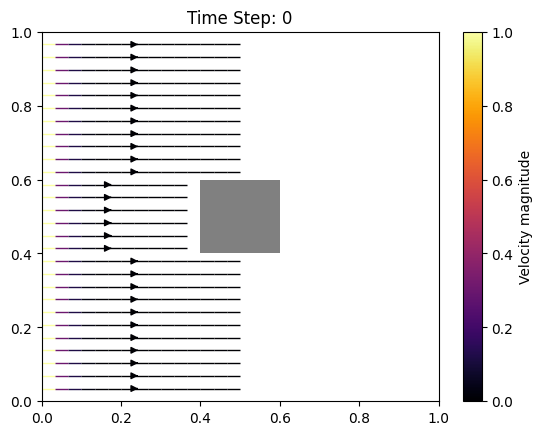

In [5]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Rectangle
import numpy as np
import matplotlib.colors as mcolors
from matplotlib.animation import PillowWriter

def get_obstacle_mask(nx, ny, dx, dy):
    x_center, y_center = nx // 2, ny // 2
    x_width, y_height = nx // 10, ny // 10

    obstacle = plt.Rectangle(((x_center - x_width) * dx, (y_center - y_height) * dy), 2 * x_width * dx, 2 * y_height * dy, facecolor='gray')

    return obstacle

# Visualization function
def update(frame_number):
    global u, v, p, dx, dy, dt, nu

    ax.clear()
    strm = ax.streamplot(X, Y, u_steps[frame_number], v_steps[frame_number], color=(np.sqrt(u_steps[frame_number]**2 + v_steps[frame_number]**2)), linewidth=1, cmap=cm.inferno)

    obstacle = get_obstacle_mask(ax, u.shape[1], u.shape[0])
    ax.add_patch(obstacle)

    ax.set_title("Time Step: {}".format(frame_number))
    ax.set_xlim(0, 1)  # Set x-axis limits
    ax.set_ylim(0, 1)  # Set y-axis limits

fig, ax = plt.subplots()
X, Y = np.meshgrid(np.arange(0, 1 + dx, dx), np.arange(0, 1 + dy, dy))

# Create a ScalarMappable object
norm = mcolors.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap=cm.inferno, norm=norm)
sm.set_array([])

# Add a colorbar to the figure using the ScalarMappable object
fig.colorbar(sm, ax=ax, label='Velocity magnitude')

ani = FuncAnimation(fig, update, frames=range(steps), blit=False, repeat=False)

In [6]:
writer = PillowWriter(fps=5)
ani.save('./navier_stokes.gif', writer=writer)

In [7]:
from IPython.display import Image

Image(url="./navier_stokes.gif")